In [20]:
"""
In this script, we will

Apply inference with our current script
Apply Tracking with sort.py or strong_sort(if possible)
"""

import torch 
from os import path, listdir
#Use os.path to determine if your local path exists

model = torch.hub.load('.','custom','best.pt',source='local')
model.conf = .4 #Minimum .5 confidence threshold
path = "data/localization/test/"
images = listdir(path+"images/")
images = [path+"images/"+image for image in images]
videos = listdir(path+"videos/")
videos = [path+"videos/"+video for video in videos]

YOLOv5 🚀 v7.0-74-g833be21a7 Python-3.8.10 torch-1.13.0+cu117 CPU

Fusing layers... 
Model summary: 212 layers, 20893344 parameters, 0 gradients
Adding AutoShape... 


In [21]:
from sort import sort

Traffic detected(Vehicles & Pedestrians): 1


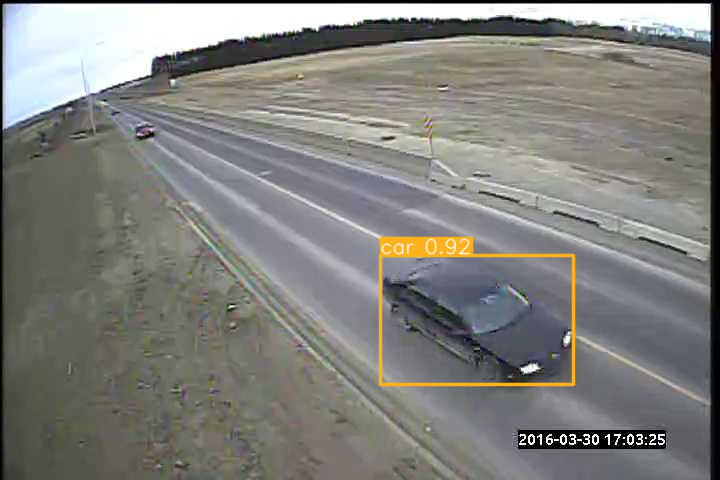

Saved 1 image to runs/detect/image_run


Traffic detected(Vehicles & Pedestrians): 1


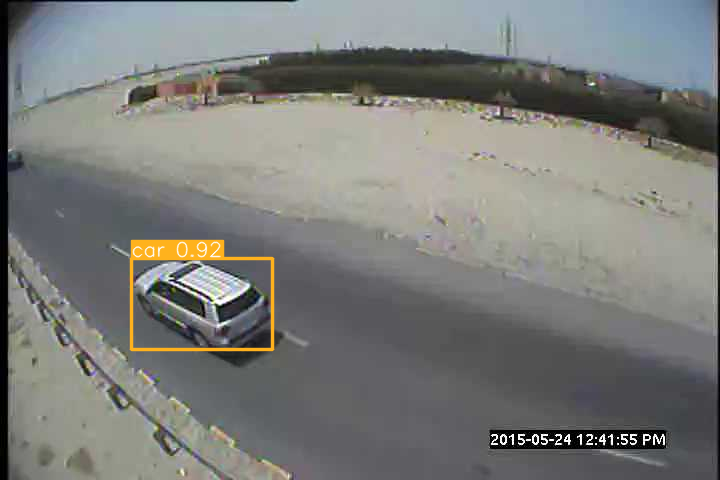

Saved 1 image to runs/detect/image_run


Traffic detected(Vehicles & Pedestrians): 3


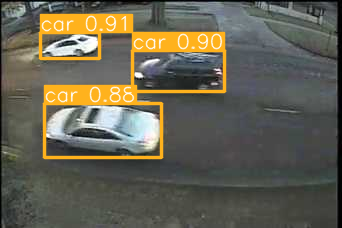

Saved 1 image to runs/detect/image_run


Traffic detected(Vehicles & Pedestrians): 2


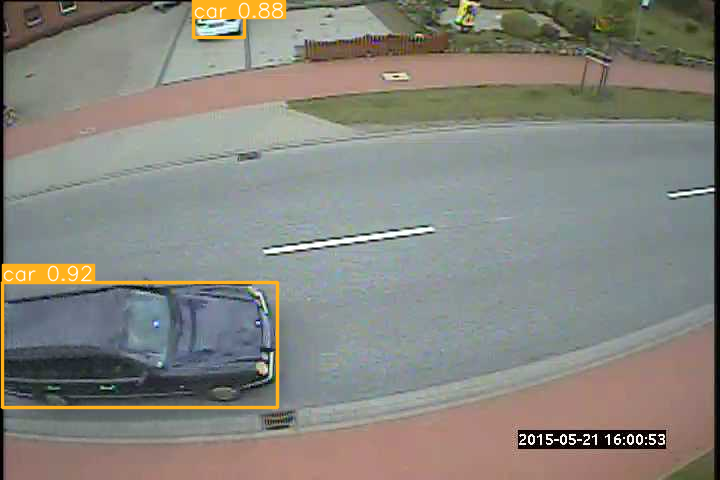

Saved 1 image to runs/detect/image_run


Traffic detected(Vehicles & Pedestrians): 2


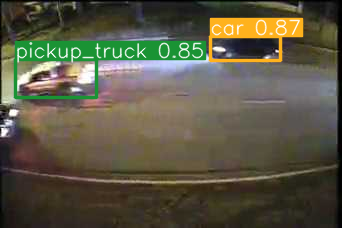

Saved 1 image to runs/detect/image_run


Traffic detected(Vehicles & Pedestrians): 5


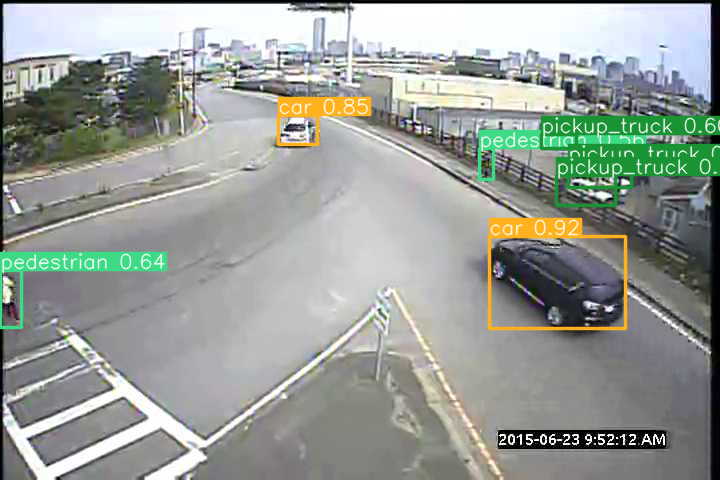

Saved 1 image to runs/detect/image_run


Traffic detected(Vehicles & Pedestrians): 5


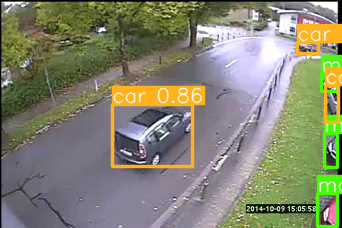

Saved 1 image to runs/detect/image_run


Traffic detected(Vehicles & Pedestrians): 3


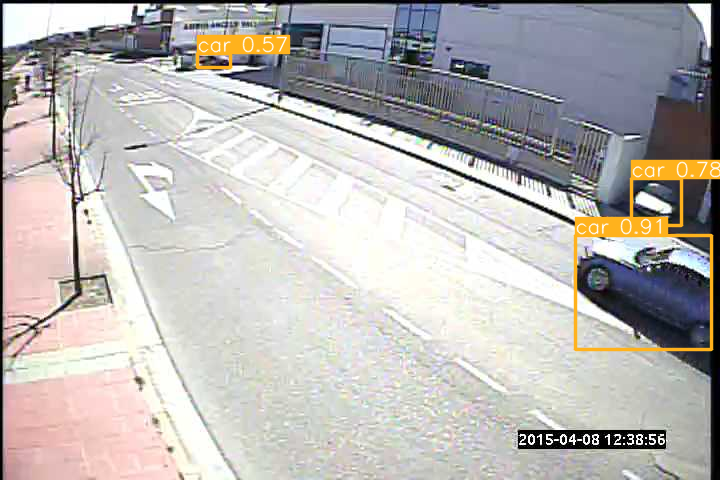

Saved 1 image to runs/detect/image_run


Traffic detected(Vehicles & Pedestrians): 2


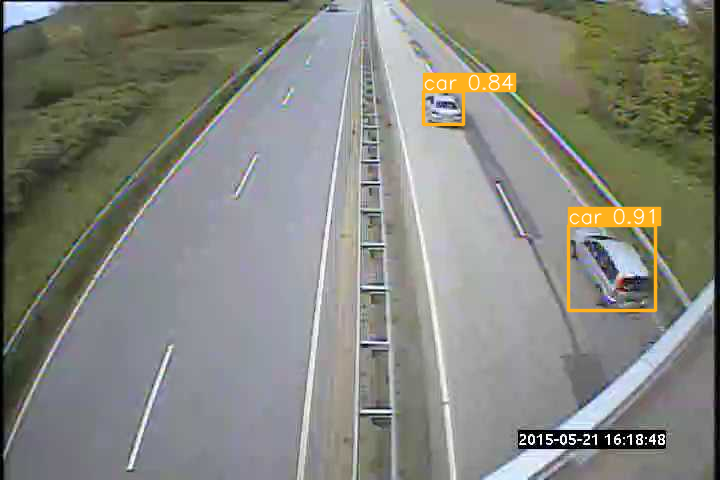

Saved 1 image to runs/detect/image_run


Traffic detected(Vehicles & Pedestrians): 3


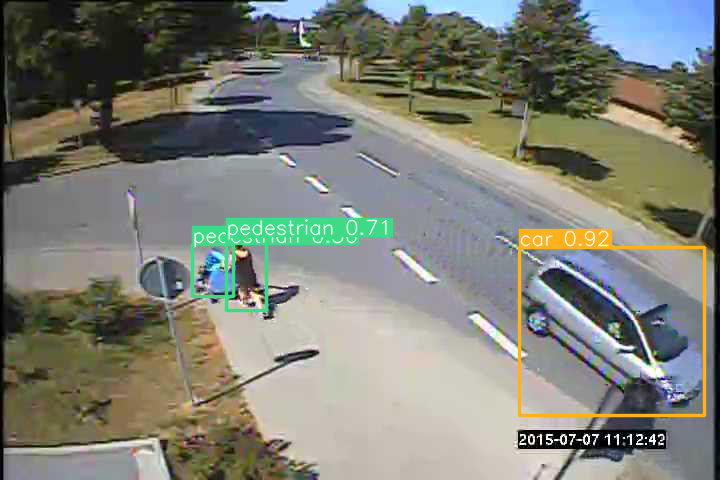

Saved 1 image to runs/detect/image_run


[1, 1, 3, 2, 2, 5, 5, 3, 2, 3]


In [22]:
import numpy as np
import pandas as pd
"""
Count number of cars per image
"""
count_list = []
limit = 0
for image in images:
    if limit == 10:
        break
    count = 0
    ids = set()
    results = model(image)
    #results.show()
    #Retrieving boundingbox data as dataframe 
    #Dataframe Format (xyxy attribute):
    #(xmin,ymin,xmax,ymax,confidence,label_value,label)
    df = results.pandas().xyxy[0]
    data = df.iloc[:][:5].to_numpy()
    data = data[:,:5]
    
    tracker=sort.Sort()
    track_res = tracker.update(data)
    for vehicle in track_res[:,4]:
        if vehicle not in ids:
            ids.add(vehicle)
            count += 1
        
    #Save within the same folder
    print("Traffic detected(Vehicles & Pedestrians):",count)
    results.show()#Use this line if you have a limit
    results.save(save_dir='runs/detect/image_run',
                 exist_ok=True)
    count_list.append(count)
    limit += 1

print(count_list)

In [51]:
import cv2
from PIL import Image, ImageDraw, ImageFont
"""
TODO:
1) Live Video
"""
count_list = []
vid_count = 1
for video in videos:
    print("Currently processing video ",vid_count)
    vid = cv2.VideoCapture(video)
    ret,frame = vid.read()
    image_frames = []
    
    #Store tracking info per video
    tracker=sort.Sort() 
    ids = set()
    count = 0
    
    #Set number of frames to look at for testing purposes
    #limit = 10
    while(ret):
        #if(limit == 0):
        #    break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGBA)
        im = Image.fromarray(frame)
        results = model(im)
        #Retrieving boundingbox data as dataframe 
        #Dataframe Format (xyxy attribute):
        #(xmin,ymin,xmax,ymax,confidence,label_value,label)
        df = results.pandas().xyxy[0]        
        data = df.iloc[:][:5].to_numpy()
        data = data[:,:5].astype('float64')
        
        
        #Updated with ids on the camera
        track_res = tracker.update(data)
        #image_frames.append(Image.fromarray(results.render(labels = False)[0]))

        for vehicle in track_res[:,4]:
            if vehicle not in ids:
                ids.add(vehicle)
                count += 1
        
        #Image WITH BOX PREDICTIONS AND COUNT
        new_res = results.render(labels=False)[0]        
        im = Image.fromarray(new_res)
        
        
        im_draw = ImageDraw.Draw(im)
        myFont = ImageFont.truetype('Oswald-Bold.ttf', 20)
        im_draw.text((im.width/10,im.height*9/10), 
                     "Count="+str(count),fill='white',font=myFont,
                     anchor = None, spacing = 4,
                     align="left",direction=None,
                     features=None,language=None,
                     stroke_width=1, stroke_fill="black")
        
        #Check if the images are being properly converted:
        #im.show()
        image_frames.append(im)#Append for conversion to video
        
        #limit -= 1
        ret, frame = vid.read()
    
    #Save video as gif
    image_frames[0].save('runs/detect/videos/video'+str(vid_count)+".gif",
                         save_all=True, optimize=True,quality=95,append_images=image_frames[1:],loop=0)
    vid_count+=1
    
    
    #Cars/Pedestrians counted    
    count_list.append(count)
    
print("Final Count list:", count_list)

Currently processing video  1
Currently processing video  2
Currently processing video  3
Currently processing video  4
Currently processing video  5
Currently processing video  6
Currently processing video  7
Currently processing video  8
Currently processing video  9
Currently processing video  10
Currently processing video  11
Currently processing video  12
Currently processing video  13
Currently processing video  14
Currently processing video  15
Currently processing video  16
Final Count list: [0, 0, 30, 18, 39, 16, 19, 33, 24, 3, 48, 41, 25, 55, 23, 11]
